Importing Necessary Libraries

In [55]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Loading MNIST Dataset

In [56]:
(X_train, _), (_, _) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


Displaying One training image

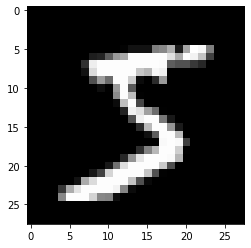

In [57]:
plt.imshow(X_train[0].reshape(28,28), cmap="gray")

Generate latent points of the shape n_samplesxlatent_dim(100)

In [58]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

Generate n real samples with 1 as a label, i.e. real image

In [59]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

Generate n fake samples using the generator with 0 as a label, i.e. fake image

In [60]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

Summarize the performance. This includes generating a fake sample, plotting it, and finally saving the model.

In [61]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

Plot the results

In [62]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

Descriminator: couple of Dense, Flatten and Dropout layers with leaky relu as an activation function in hidden layers and sigmoid in the final layer, adam as an optimizer and binary cross-entropy as a loss function as the discriminator’s task is to perform the binary classification.

In [63]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [64]:
discriminator = define_discriminator()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Generator:  couple of Dense layers to define the generator model with again leaky relu as an activation function in hidden layers and tanh in the final layer. The generated images G(z) will be of the shape 28x28x1

In [78]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=latent_dim,)
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [79]:
generator = define_generator(100)

Build the Gan model:  providing z as input and D(G(z)) as an output to our model. We are using adam as an optimizer and binary cross-entropy as a loss function.

In [43]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [80]:
gan_model = define_gan(generator, discriminator)

Train the generator and the discriminator. To train the Discriminator, it first generates real samples, updates the discriminator’s weights, generates fake samples, and then updates the discriminator’s weights again. To train the Generator, it first generates latent points, generates labels as 1 to fool the discriminator, and then updates the generator’s weights. 

In [81]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

Calling the train function with 100 random samples, 20 epochs, and 64 as batch size

2/2 [==============================] - 0s 4ms/step
>1, dr[0.453,0.812], df[0.044,1.000], g[3.151,0.000]
2/2 [==============================] - 0s 6ms/step
>2, dr[0.008,1.000], df[0.044,1.000], g[3.155,0.000]
2/2 [==============================] - 0s 7ms/step
>3, dr[0.014,0.984], df[0.044,1.000], g[3.154,0.000]
2/2 [==============================] - 0s 5ms/step
>4, dr[0.006,1.000], df[0.044,1.000], g[3.159,0.000]
2/2 [==============================] - 0s 5ms/step
>5, dr[0.001,1.000], df[0.044,1.000], g[3.153,0.000]
2/2 [==============================] - 0s 4ms/step
>6, dr[0.000,1.000], df[0.044,1.000], g[3.147,0.000]
2/2 [==============================] - 0s 5ms/step
>7, dr[0.000,1.000], df[0.044,1.000], g[3.173,0.000]
2/2 [==============================] - 0s 5ms/step
>8, dr[0.002,1.000], df[0.043,1.000], g[3.155,0.000]
2/2 [==============================] - 0s 6ms/step
>9, dr[0.011,1.000], df[0.044,1.000], g[3.137,0.000]
2/2 [==============================] - 0s 5ms/step
>10, dr[0.000

>Saved: model_0937.h5
2/2 [==============================] - 0s 8ms/step
>938, dr[0.002,1.000], df[0.020,1.000], g[4.602,0.000]
2/2 [==============================] - 0s 6ms/step
>939, dr[0.000,1.000], df[0.019,1.000], g[4.623,0.000]
2/2 [==============================] - 0s 6ms/step
>940, dr[0.000,1.000], df[0.015,1.000], g[4.614,0.000]
2/2 [==============================] - 0s 5ms/step
>941, dr[0.000,1.000], df[0.016,1.000], g[4.773,0.000]
2/2 [==============================] - 0s 6ms/step
>942, dr[0.001,1.000], df[0.010,1.000], g[4.606,0.000]
2/2 [==============================] - 0s 6ms/step
>943, dr[0.000,1.000], df[0.022,1.000], g[4.724,0.000]
2/2 [==============================] - 0s 5ms/step
>944, dr[0.001,1.000], df[0.009,1.000], g[4.712,0.000]
2/2 [==============================] - 0s 4ms/step
>945, dr[0.000,1.000], df[0.012,1.000], g[4.682,0.000]
2/2 [==============================] - 0s 6ms/step
>946, dr[0.000,1.000], df[0.014,1.000], g[4.611,0.000]
2/2 [===================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


>Saved: model_1874.h5
2/2 [==============================] - 0s 7ms/step
>1875, dr[0.000,1.000], df[0.006,1.000], g[5.551,0.000]
2/2 [==============================] - 0s 4ms/step
>1876, dr[0.000,1.000], df[0.011,1.000], g[5.739,0.000]
2/2 [==============================] - 0s 8ms/step
>1877, dr[0.000,1.000], df[0.007,1.000], g[5.621,0.000]
2/2 [==============================] - 0s 3ms/step
>1878, dr[0.000,1.000], df[0.008,1.000], g[5.257,0.000]
2/2 [==============================] - 0s 7ms/step
>1879, dr[0.000,1.000], df[0.019,1.000], g[5.306,0.000]
2/2 [==============================] - 0s 5ms/step
>1880, dr[0.087,0.969], df[0.035,0.984], g[4.239,0.000]
2/2 [==============================] - 0s 5ms/step
>1881, dr[0.000,1.000], df[0.080,0.969], g[4.634,0.016]
2/2 [==============================] - 0s 5ms/step
>1882, dr[0.000,1.000], df[0.048,0.984], g[5.407,0.000]
2/2 [==============================] - 0s 6ms/step
>1883, dr[0.000,1.000], df[0.006,1.000], g[5.709,0.000]
2/2 [==========

>Saved: model_2811.h5
2/2 [==============================] - 0s 9ms/step
>2812, dr[0.048,0.984], df[0.028,1.000], g[4.329,0.000]
2/2 [==============================] - 0s 9ms/step
>2813, dr[0.000,1.000], df[0.028,1.000], g[4.512,0.000]
2/2 [==============================] - 0s 9ms/step
>2814, dr[0.000,1.000], df[0.016,1.000], g[4.648,0.016]
2/2 [==============================] - 0s 8ms/step
>2815, dr[0.068,0.984], df[0.056,0.969], g[4.973,0.000]
2/2 [==============================] - 0s 8ms/step
>2816, dr[0.088,0.984], df[0.021,1.000], g[4.728,0.000]
2/2 [==============================] - 0s 6ms/step
>2817, dr[0.186,0.984], df[0.021,1.000], g[3.628,0.047]
2/2 [==============================] - 0s 4ms/step
>2818, dr[0.000,1.000], df[0.075,1.000], g[4.214,0.016]
2/2 [==============================] - 0s 8ms/step
>2819, dr[0.000,1.000], df[0.071,0.969], g[5.475,0.000]
2/2 [==============================] - 0s 9ms/step
>2820, dr[0.002,1.000], df[0.006,1.000], g[5.897,0.000]
2/2 [==========

>Saved: model_3748.h5
2/2 [==============================] - 0s 5ms/step
>3749, dr[0.000,1.000], df[0.028,1.000], g[4.825,0.000]
2/2 [==============================] - 0s 5ms/step
>3750, dr[0.000,1.000], df[0.011,1.000], g[4.789,0.000]
2/2 [==============================] - 0s 3ms/step
>3751, dr[0.005,1.000], df[0.010,1.000], g[4.708,0.000]
2/2 [==============================] - 0s 4ms/step
>3752, dr[0.183,0.953], df[0.046,1.000], g[3.009,0.047]
2/2 [==============================] - 0s 5ms/step
>3753, dr[0.000,1.000], df[0.144,0.953], g[3.743,0.000]
2/2 [==============================] - 0s 9ms/step
>3754, dr[0.060,0.984], df[0.044,1.000], g[3.889,0.016]
2/2 [==============================] - 0s 10ms/step
>3755, dr[0.000,1.000], df[0.043,0.984], g[4.344,0.000]
2/2 [==============================] - 0s 9ms/step
>3756, dr[0.004,1.000], df[0.017,1.000], g[4.498,0.000]
2/2 [==============================] - 0s 11ms/step
>3757, dr[0.004,1.000], df[0.017,1.000], g[4.305,0.000]
2/2 [========

>Saved: model_4685.h5
2/2 [==============================] - 0s 11ms/step
>4686, dr[0.002,1.000], df[0.018,1.000], g[4.248,0.000]
2/2 [==============================] - 0s 11ms/step
>4687, dr[0.000,1.000], df[0.019,1.000], g[4.434,0.000]
2/2 [==============================] - 0s 10ms/step
>4688, dr[0.000,1.000], df[0.016,1.000], g[4.522,0.000]
2/2 [==============================] - 0s 7ms/step
>4689, dr[0.000,1.000], df[0.032,0.984], g[4.603,0.000]
2/2 [==============================] - 0s 11ms/step
>4690, dr[0.000,1.000], df[0.011,1.000], g[4.838,0.000]
2/2 [==============================] - 0s 5ms/step
>4691, dr[0.000,1.000], df[0.020,1.000], g[5.025,0.000]
2/2 [==============================] - 0s 6ms/step
>4692, dr[0.003,1.000], df[0.011,1.000], g[4.881,0.000]
2/2 [==============================] - 0s 7ms/step
>4693, dr[0.000,1.000], df[0.028,0.984], g[4.794,0.000]
2/2 [==============================] - 0s 12ms/step
>4694, dr[0.018,0.984], df[0.014,1.000], g[4.357,0.016]
2/2 [=====

>Saved: model_5622.h5
2/2 [==============================] - 0s 6ms/step
>5623, dr[0.015,0.984], df[0.013,1.000], g[4.740,0.000]
2/2 [==============================] - 0s 12ms/step
>5624, dr[0.016,0.984], df[0.023,1.000], g[4.112,0.000]
2/2 [==============================] - 0s 11ms/step
>5625, dr[0.003,1.000], df[0.055,1.000], g[4.559,0.000]
2/2 [==============================] - 0s 4ms/step
>5626, dr[0.005,1.000], df[0.015,1.000], g[5.325,0.000]
2/2 [==============================] - 0s 7ms/step
>5627, dr[0.086,0.969], df[0.029,1.000], g[4.660,0.000]
2/2 [==============================] - 0s 5ms/step
>5628, dr[0.012,1.000], df[0.029,1.000], g[4.290,0.000]
2/2 [==============================] - 0s 11ms/step
>5629, dr[0.000,1.000], df[0.032,1.000], g[4.725,0.000]
2/2 [==============================] - 0s 5ms/step
>5630, dr[0.074,0.969], df[0.138,0.969], g[4.854,0.000]
2/2 [==============================] - 0s 4ms/step
>5631, dr[0.000,1.000], df[0.011,1.000], g[5.386,0.000]
2/2 [=======

>Saved: model_6559.h5
2/2 [==============================] - 0s 12ms/step
>6560, dr[0.000,1.000], df[0.019,1.000], g[5.296,0.000]
2/2 [==============================] - 0s 4ms/step
>6561, dr[0.020,0.984], df[0.015,1.000], g[4.467,0.000]
2/2 [==============================] - 0s 10ms/step
>6562, dr[0.001,1.000], df[0.036,1.000], g[4.850,0.000]
2/2 [==============================] - 0s 4ms/step
>6563, dr[0.016,0.984], df[0.029,1.000], g[5.317,0.000]
2/2 [==============================] - 0s 4ms/step
>6564, dr[0.000,1.000], df[0.013,1.000], g[5.450,0.000]
2/2 [==============================] - 0s 4ms/step
>6565, dr[0.074,0.984], df[0.013,1.000], g[5.382,0.000]
2/2 [==============================] - 0s 6ms/step
>6566, dr[0.014,0.984], df[0.059,0.984], g[5.175,0.000]
2/2 [==============================] - 0s 12ms/step
>6567, dr[0.078,0.969], df[0.064,0.969], g[5.048,0.000]
2/2 [==============================] - 0s 12ms/step
>6568, dr[0.000,1.000], df[0.032,1.000], g[5.751,0.000]
2/2 [======

>Saved: model_7496.h5
2/2 [==============================] - 0s 8ms/step
>7497, dr[0.014,0.984], df[0.024,1.000], g[4.758,0.000]
2/2 [==============================] - 0s 12ms/step
>7498, dr[0.002,1.000], df[0.013,1.000], g[4.747,0.000]
2/2 [==============================] - 0s 12ms/step
>7499, dr[0.002,1.000], df[0.025,0.984], g[4.721,0.000]
2/2 [==============================] - 0s 11ms/step
>7500, dr[0.036,0.984], df[0.020,1.000], g[4.566,0.000]
2/2 [==============================] - 0s 9ms/step
>7501, dr[0.002,1.000], df[0.042,0.984], g[4.860,0.000]
2/2 [==============================] - 0s 19ms/step
>7502, dr[0.022,0.984], df[0.041,1.000], g[4.676,0.000]
2/2 [==============================] - 0s 4ms/step
>7503, dr[0.003,1.000], df[0.018,1.000], g[4.726,0.000]
2/2 [==============================] - 0s 12ms/step
>7504, dr[0.000,1.000], df[0.020,1.000], g[5.086,0.000]
2/2 [==============================] - 0s 5ms/step
>7505, dr[0.106,0.953], df[0.114,0.984], g[4.086,0.016]
2/2 [=====

>Saved: model_8433.h5
2/2 [==============================] - 0s 8ms/step
>8434, dr[0.027,0.984], df[0.036,0.984], g[4.824,0.000]
2/2 [==============================] - 0s 13ms/step
>8435, dr[0.163,0.969], df[0.069,1.000], g[4.098,0.016]
2/2 [==============================] - 0s 15ms/step
>8436, dr[0.000,1.000], df[0.028,1.000], g[4.456,0.000]
2/2 [==============================] - 0s 10ms/step
>8437, dr[0.006,1.000], df[0.025,1.000], g[4.622,0.000]
2/2 [==============================] - 0s 4ms/step
>8438, dr[0.000,1.000], df[0.019,1.000], g[4.747,0.000]
2/2 [==============================] - 0s 5ms/step
>8439, dr[0.022,0.984], df[0.015,1.000], g[4.467,0.000]
2/2 [==============================] - 0s 9ms/step
>8440, dr[0.001,1.000], df[0.033,0.984], g[4.749,0.016]
2/2 [==============================] - 0s 4ms/step
>8441, dr[0.003,1.000], df[0.015,1.000], g[5.059,0.000]
2/2 [==============================] - 0s 5ms/step
>8442, dr[0.027,0.984], df[0.048,0.984], g[4.852,0.000]
2/2 [=======

>Saved: model_9370.h5
2/2 [==============================] - 0s 10ms/step
>9371, dr[0.001,1.000], df[0.039,0.984], g[5.213,0.016]
2/2 [==============================] - 0s 7ms/step
>9372, dr[0.000,1.000], df[0.016,1.000], g[5.628,0.016]
2/2 [==============================] - 0s 5ms/step
>9373, dr[0.114,0.984], df[0.198,0.984], g[5.570,0.000]
2/2 [==============================] - 0s 5ms/step
>9374, dr[0.037,0.984], df[0.167,0.969], g[5.431,0.000]
2/2 [==============================] - 0s 3ms/step
>9375, dr[0.032,0.984], df[0.026,1.000], g[5.181,0.000]
2/2 [==============================] - 0s 5ms/step
>9376, dr[0.005,1.000], df[0.036,0.984], g[5.591,0.000]
2/2 [==============================] - 0s 4ms/step
>9377, dr[0.068,0.984], df[0.015,1.000], g[5.258,0.000]
2/2 [==============================] - 0s 4ms/step
>9378, dr[0.105,0.969], df[0.134,0.969], g[4.413,0.000]
2/2 [==============================] - 0s 4ms/step
>9379, dr[0.000,1.000], df[0.021,1.000], g[4.698,0.000]
2/2 [=========

>Saved: model_10307.h5
2/2 [==============================] - 0s 13ms/step
>10308, dr[0.005,1.000], df[0.012,1.000], g[4.926,0.000]
2/2 [==============================] - 0s 4ms/step
>10309, dr[0.006,1.000], df[0.017,1.000], g[4.512,0.000]
2/2 [==============================] - 0s 5ms/step
>10310, dr[0.033,0.984], df[0.045,1.000], g[4.402,0.016]
2/2 [==============================] - 0s 4ms/step
>10311, dr[0.010,1.000], df[0.074,0.984], g[5.049,0.000]
2/2 [==============================] - 0s 5ms/step
>10312, dr[0.047,0.984], df[0.031,1.000], g[5.169,0.000]
2/2 [==============================] - 0s 9ms/step
>10313, dr[0.017,1.000], df[0.101,0.984], g[4.978,0.000]
2/2 [==============================] - 0s 7ms/step
>10314, dr[0.211,0.938], df[0.106,0.984], g[4.007,0.016]
2/2 [==============================] - 0s 5ms/step
>10315, dr[0.020,1.000], df[0.055,1.000], g[4.166,0.000]
2/2 [==============================] - 0s 8ms/step
>10316, dr[0.055,0.969], df[0.084,0.984], g[4.348,0.000]
2/2 

>Saved: model_11244.h5
2/2 [==============================] - 0s 4ms/step
>11245, dr[0.001,1.000], df[0.011,1.000], g[4.803,0.016]
2/2 [==============================] - 0s 5ms/step
>11246, dr[0.097,0.969], df[0.051,0.984], g[4.373,0.000]
2/2 [==============================] - 0s 7ms/step
>11247, dr[0.000,1.000], df[0.036,0.984], g[4.803,0.000]
2/2 [==============================] - 0s 3ms/step
>11248, dr[0.029,0.984], df[0.021,1.000], g[4.727,0.000]
2/2 [==============================] - 0s 4ms/step
>11249, dr[0.029,0.984], df[0.131,0.984], g[5.094,0.000]
2/2 [==============================] - 0s 8ms/step
>11250, dr[0.027,0.984], df[0.030,1.000], g[4.832,0.000]
2/2 [==============================] - 0s 4ms/step
>11251, dr[0.014,0.984], df[0.033,0.984], g[4.998,0.016]
2/2 [==============================] - 0s 13ms/step
>11252, dr[0.089,0.984], df[0.011,1.000], g[4.642,0.000]
2/2 [==============================] - 0s 4ms/step
>11253, dr[0.134,0.969], df[0.029,0.984], g[4.069,0.000]
2/2 

>Saved: model_12181.h5
2/2 [==============================] - 0s 3ms/step
>12182, dr[0.060,0.969], df[0.060,0.984], g[4.275,0.016]
2/2 [==============================] - 0s 5ms/step
>12183, dr[0.004,1.000], df[0.061,0.969], g[4.921,0.000]
2/2 [==============================] - 0s 4ms/step
>12184, dr[0.121,0.953], df[0.080,0.969], g[4.741,0.000]
2/2 [==============================] - 0s 4ms/step
>12185, dr[0.035,0.984], df[0.045,1.000], g[4.746,0.000]
2/2 [==============================] - 0s 4ms/step
>12186, dr[0.003,1.000], df[0.023,1.000], g[4.925,0.000]
2/2 [==============================] - 0s 4ms/step
>12187, dr[0.008,1.000], df[0.030,1.000], g[5.240,0.000]
2/2 [==============================] - 0s 4ms/step
>12188, dr[0.022,0.984], df[0.024,1.000], g[5.003,0.000]
2/2 [==============================] - 0s 4ms/step
>12189, dr[0.007,1.000], df[0.017,1.000], g[5.190,0.016]
2/2 [==============================] - 0s 4ms/step
>12190, dr[0.017,0.984], df[0.072,0.969], g[5.195,0.000]
2/2 [

>Saved: model_13118.h5
2/2 [==============================] - 0s 11ms/step
>13119, dr[0.073,0.984], df[0.011,1.000], g[5.533,0.000]
2/2 [==============================] - 0s 11ms/step
>13120, dr[0.240,0.938], df[0.101,0.969], g[4.985,0.000]
2/2 [==============================] - 0s 22ms/step
>13121, dr[0.017,1.000], df[0.086,0.953], g[5.591,0.000]
2/2 [==============================] - 0s 5ms/step
>13122, dr[0.069,0.984], df[0.009,1.000], g[4.998,0.000]
2/2 [==============================] - 0s 9ms/step
>13123, dr[0.051,0.984], df[0.029,1.000], g[4.597,0.016]
2/2 [==============================] - 0s 17ms/step
>13124, dr[0.101,0.969], df[0.114,0.969], g[5.013,0.016]
2/2 [==============================] - 0s 15ms/step
>13125, dr[0.013,0.984], df[0.043,0.984], g[5.812,0.016]
2/2 [==============================] - 0s 4ms/step
>13126, dr[0.087,0.953], df[0.027,1.000], g[4.880,0.031]
2/2 [==============================] - 0s 5ms/step
>13127, dr[0.061,0.984], df[0.095,0.984], g[5.157,0.016]


>Saved: model_14055.h5
2/2 [==============================] - 0s 5ms/step
>14056, dr[0.048,0.969], df[0.141,0.969], g[5.113,0.000]
2/2 [==============================] - 0s 5ms/step
>14057, dr[0.028,0.984], df[0.030,1.000], g[5.581,0.000]
2/2 [==============================] - 0s 6ms/step
>14058, dr[0.135,0.953], df[0.044,1.000], g[4.738,0.031]
2/2 [==============================] - 0s 3ms/step
>14059, dr[0.092,0.969], df[0.092,0.969], g[4.478,0.031]
2/2 [==============================] - 0s 13ms/step
>14060, dr[0.002,1.000], df[0.072,0.953], g[5.506,0.000]
2/2 [==============================] - 0s 12ms/step
>14061, dr[0.048,0.969], df[0.068,0.969], g[6.001,0.000]
2/2 [==============================] - 0s 4ms/step
>14062, dr[0.149,0.953], df[0.061,0.984], g[4.683,0.047]
2/2 [==============================] - 0s 11ms/step
>14063, dr[0.057,0.984], df[0.058,0.984], g[4.572,0.000]
2/2 [==============================] - 0s 5ms/step
>14064, dr[0.041,0.984], df[0.067,0.984], g[5.041,0.000]
2/

>Saved: model_14992.h5
2/2 [==============================] - 0s 11ms/step
>14993, dr[0.002,1.000], df[0.069,0.984], g[4.924,0.000]
2/2 [==============================] - 0s 5ms/step
>14994, dr[0.017,1.000], df[0.013,1.000], g[5.297,0.000]
2/2 [==============================] - 0s 4ms/step
>14995, dr[0.108,0.969], df[0.092,0.969], g[4.867,0.000]
2/2 [==============================] - 0s 10ms/step
>14996, dr[0.069,0.984], df[0.045,0.984], g[4.606,0.000]
2/2 [==============================] - 0s 3ms/step
>14997, dr[0.076,0.938], df[0.038,0.984], g[4.441,0.016]
2/2 [==============================] - 0s 8ms/step
>14998, dr[0.012,0.984], df[0.058,0.984], g[4.703,0.016]
2/2 [==============================] - 0s 5ms/step
>14999, dr[0.034,0.984], df[0.150,0.969], g[5.015,0.031]
2/2 [==============================] - 0s 5ms/step
>15000, dr[0.133,0.953], df[0.018,1.000], g[4.867,0.016]
2/2 [==============================] - 0s 6ms/step
>15001, dr[0.012,1.000], df[0.101,0.984], g[5.435,0.000]
2/2

>Saved: model_15929.h5
2/2 [==============================] - 0s 13ms/step
>15930, dr[0.022,0.984], df[0.041,0.984], g[6.393,0.000]
2/2 [==============================] - 0s 4ms/step
>15931, dr[0.518,0.859], df[0.035,1.000], g[4.117,0.047]
2/2 [==============================] - 0s 6ms/step
>15932, dr[0.007,1.000], df[0.261,0.938], g[5.081,0.016]
2/2 [==============================] - 0s 7ms/step
>15933, dr[0.031,1.000], df[0.086,0.969], g[5.730,0.016]
2/2 [==============================] - 0s 5ms/step
>15934, dr[0.170,0.922], df[0.049,0.984], g[5.378,0.016]
2/2 [==============================] - 0s 5ms/step
>15935, dr[0.108,0.969], df[0.168,0.938], g[5.377,0.031]
2/2 [==============================] - 0s 5ms/step
>15936, dr[0.263,0.891], df[0.085,0.984], g[4.611,0.016]
2/2 [==============================] - 0s 4ms/step
>15937, dr[0.010,1.000], df[0.142,0.922], g[5.167,0.000]
2/2 [==============================] - 0s 7ms/step
>15938, dr[0.025,0.984], df[0.030,0.984], g[5.925,0.000]
2/2 

>Saved: model_16866.h5
2/2 [==============================] - 0s 4ms/step
>16867, dr[0.226,0.938], df[0.156,0.938], g[4.781,0.016]
2/2 [==============================] - 0s 4ms/step
>16868, dr[0.040,0.984], df[0.045,0.984], g[4.761,0.000]
2/2 [==============================] - 0s 4ms/step
>16869, dr[0.040,0.969], df[0.087,0.969], g[5.574,0.000]
2/2 [==============================] - 0s 5ms/step
>16870, dr[0.123,0.953], df[0.023,1.000], g[4.894,0.000]
2/2 [==============================] - 0s 6ms/step
>16871, dr[0.027,0.984], df[0.073,0.984], g[4.924,0.000]
2/2 [==============================] - 0s 6ms/step
>16872, dr[0.038,0.984], df[0.030,1.000], g[5.206,0.000]
2/2 [==============================] - 0s 6ms/step
>16873, dr[0.154,0.906], df[0.107,0.969], g[4.193,0.031]
2/2 [==============================] - 0s 4ms/step
>16874, dr[0.050,0.969], df[0.114,0.953], g[4.158,0.016]
2/2 [==============================] - 0s 5ms/step
>16875, dr[0.010,1.000], df[0.031,1.000], g[4.919,0.000]
2/2 [

>Saved: model_17803.h5
2/2 [==============================] - 0s 4ms/step
>17804, dr[0.100,0.984], df[0.107,0.953], g[4.662,0.016]
2/2 [==============================] - 0s 4ms/step
>17805, dr[0.043,0.969], df[0.028,1.000], g[4.933,0.016]
2/2 [==============================] - 0s 9ms/step
>17806, dr[0.062,0.953], df[0.218,0.953], g[5.163,0.000]
2/2 [==============================] - 0s 10ms/step
>17807, dr[0.191,0.938], df[0.023,1.000], g[4.730,0.016]
2/2 [==============================] - 0s 4ms/step
>17808, dr[0.168,0.938], df[0.082,0.969], g[4.690,0.031]
2/2 [==============================] - 0s 4ms/step
>17809, dr[0.120,0.953], df[0.154,0.953], g[5.148,0.016]
2/2 [==============================] - 0s 4ms/step
>17810, dr[0.266,0.922], df[0.134,0.984], g[4.472,0.016]
2/2 [==============================] - 0s 4ms/step
>17811, dr[0.104,0.938], df[0.139,0.984], g[4.292,0.016]
2/2 [==============================] - 0s 6ms/step
>17812, dr[0.012,1.000], df[0.052,0.984], g[4.946,0.016]
2/2 

>Saved: model_18740.h5


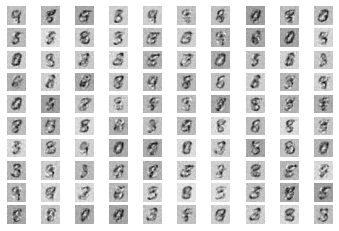

In [82]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

Loading the latest saved model, generating latent points, using the loaded model for prediction, and plotting the results.

4/4 [==============================] - 0s 3ms/step


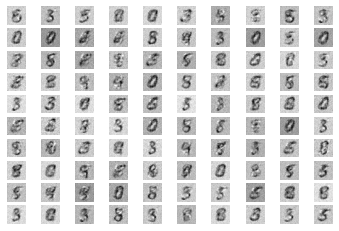

In [83]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

Display the Generated Fake Images

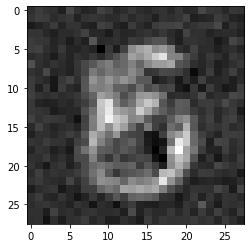

In [84]:
plt.imshow(X[0].reshape(28,28), cmap="gray")